In [1]:
import rasterio as rio
from rasterio.windows import Window
from itertools import product
import numpy as np
import os
import matplotlib.pyplot as plt
import PIL
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import glob

In [2]:
import pandas as pd

In [3]:
config = {
    "dir_files": "/mnt/mount-point-directory/datasets2/",
    "batch_size": 12,
    "num_workers": 12,
    "experiment": "exp_1",
    "city": "birmingham-fall-2021",
    "model_trained_multi_gpu": True,
    "reshape_size": 512
}

In [4]:
# Initilization
DIR_FILES = config['dir_files']
BATCH_SIZE = config['batch_size']
NUM_WORKERS = config['num_workers']
EXPERIMENT = config['experiment']
CITY = config['city']
MODEL_TRAINED_ON_MULTIPLE_GPU = config['model_trained_multi_gpu']
RESHAPE_SIZE = config['reshape_size']

In [5]:
path_imgs = glob.glob(os.path.join(DIR_FILES, CITY, 'VRT', 'tiles', '*.jp2'))
path_road_masks = glob.glob(os.path.join(DIR_FILES, CITY, 'mask_road', 'tiles', '*.jp2'))
path_building_fps = glob.glob(os.path.join(DIR_FILES, CITY, 'mask_building_fp', 'tiles', '*.jp2'))
path_to_model = f"/mnt/mount-point-directory/geomate_driveway_detection/experiments/{EXPERIMENT}/model_best.pth.tar"
path_to_save_mask = f"/mnt/mount-point-directory/results/driveways/{CITY}/{EXPERIMENT}"

# sorting to match files
path_imgs.sort()
path_road_masks.sort()
path_building_fps.sort()

In [6]:
df = pd.DataFrame(columns = ['city', 'path_img', 'path_road_mask', 'path_building_fp'])

In [7]:
def add_entry(df_, city_name, path_imgs, path_road_masks, path_building_fps):
    """
    Add a list of img paths and sw_mask paths to the dataframe.
    In future you may change it to generalize using zip(input_values) to form a new row rather than hardcoding.
    """
    for path_img, path_road_mask, path_building_fp in zip(path_imgs, 
                                                          path_road_masks, 
                                                          path_building_fps):
        new_row = {'city': city_name,
                   'path_img': path_img,
                   'path_road_mask': path_road_mask,
                   'path_building_fp': path_building_fp
                  }
        df_ = df_.append(new_row, ignore_index=True)
    return df_

In [8]:
df = add_entry(df, CITY, path_imgs, path_road_masks, path_building_fps)

In [9]:
class TestDrivewayDataset(Dataset):
    def __init__(self, df, config):
        
        self.config = config
        self.df = df
        
#         self.reshape = self.config['reshape']
        self.reshape_size = self.config['reshape_size']
        
        self.to_pil = transforms.ToPILImage()
        self.to_tensor = transforms.ToTensor()
        
    def __len__(self):
        return(len(self.df))
    
    def transform(self, img, mask_building, mask_road):
        """
        Input Tensor, Ouput Tensor
        
        """
        
        # To Tensor
        img = torch.tensor(img)
        mask_building = torch.tensor(mask_building)
        mask_road = torch.tensor(mask_road)
        
        # To PIL image
        image = self.to_pil(img[:3])
        mask_building = self.to_pil(mask_building)
        mask_road = self.to_pil(mask_road)
        
        # Resize
        image = TF.resize(image, size = self.reshape_size, interpolation=PIL.Image.NEAREST)
        mask_building = TF.resize(mask_building, size = self.reshape_size, interpolation=PIL.Image.NEAREST)
        mask_road = TF.resize(mask_road, size = self.reshape_size, interpolation=PIL.Image.NEAREST)
        
        # Change to tensors
        image = self.to_tensor(image)
        mask_building = self.to_tensor(mask_building)
        mask_road = self.to_tensor(mask_road)
        
        # Merge input tensors to 5 channel, 3 image 1 building 1 road
        _input_stacked = torch.cat((image, mask_building, mask_road))
        
        return _input_stacked
    
    def morph_meta(self, meta):
        _meta = meta

        affine = _meta['transform']
        affine_trans = [affine.a, affine.b, affine.c, affine.d, affine.e, affine.f,]
                
        _meta.pop('transform') # removed as it might crash the program, might be fixed using a custom collate.
        _meta.pop('nodata')    # removed as it might crash the program, might be fixed using a custom collate.
        
        meta_dict = {'_meta': _meta,
                     'transform': affine_trans}
        
        return meta_dict
        
    def __getitem__(self, index):
                
        # prepapre reading paths
        path_img = self.df.iloc[index]['path_img']
        path_building = self.df.iloc[index]['path_building_fp']
        path_road = self.df.iloc[index]['path_road_mask']
        
        # read src datasets
        src_img = rio.open(path_img, mode = 'r')
        src_building = rio.open(path_building, mode ='r')
        src_road = rio.open(path_road, mode = 'r')
        
        meta = src_img.meta
        
        # read images, if you get nullpointer error in img read, there is a channel issue. Reformat the images.
        _img = src_img.read()
        _mask_building = src_building.read(1)
        _mask_road = src_road.read(1)
        
        _input_tensor = self.transform(_img, _mask_building, _mask_road)
        meta_dict = self.morph_meta(src_img.meta)
        name = path_img.split('/')[-1]
        
        return [_input_tensor, meta_dict, name]

In [10]:
# Loading the model
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

if not torch.cuda.is_available():
    checkpoint = torch.load(path_to_model, map_location=device)
else:
    checkpoint = torch.load(path_to_model)

model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False, num_classes=1, aux_loss=None)
model.backbone.conv1 = nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# original saved file with DataParallel
# create new OrderedDict that does not contain `module.`

from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in checkpoint['state_dict'].items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

# load params
if MODEL_TRAINED_ON_MULTIPLE_GPU:
    model.load_state_dict(new_state_dict)
else:
    model.load_state_dict(checkpoint['state_dict'])

In [11]:
if not os.path.isdir(path_to_save_mask):
    os.makedirs(path_to_save_mask)

In [12]:
test_ds = TestDrivewayDataset(df, config)
test_loader = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, pin_memory = True)

In [22]:
model.eval()
model.to(device)

# get the meta data of just one file
src_vrt = rio.open(df['path_img'][0])

for i, sample in tqdm(enumerate(test_loader)):
    
    with torch.no_grad():
        inputRGB = sample[0].to(device)
        outputs = model(inputRGB)
    
    for i in range(len(inputRGB)):

    #     develop output image mask
        pred = (torch.sigmoid(outputs['out'][i].squeeze().cpu()) > 0.5).numpy().astype(int)

        _pred = np.stack([pred, pred, pred], axis = 0) * 255
        _pred = _pred.astype(np.uint8)

        
    #     develop meta file
        meta = {}

        meta['driver'] = 'GTiff'    # rasterio can write only with GTiff driver
        meta['dtype'] = src_vrt.meta['dtype']
        meta['nodata'] = src_vrt.meta['nodata']
        meta['width'] = int(sample[1]['_meta']['width'][i])
        meta['height'] = int(sample[1]['_meta']['height'][i])
        meta['count'] = 3
        meta['crs'] = src_vrt.meta['crs']

        a = float(sample[1]['transform'][0][i])
        b = float(sample[1]['transform'][1][i])
        c = float(sample[1]['transform'][2][i])
        d = float(sample[1]['transform'][3][i])
        e = float(sample[1]['transform'][4][i])
        f = float(sample[1]['transform'][5][i])

        meta['transform'] = rio.Affine(a, b, c, d, e, f)

    #     saving the mask
        names = sample[2]
        output_filename = names[i].replace('.jp2', '.jp2')   # change output format to tif as using GTiff driver

        outpath = os.path.join(path_to_save_mask, output_filename)

        with rio.open(outpath, 'w', **meta) as outds:
            outds.write(_pred)
            
    break

0it [00:13, ?it/s]


In [26]:
sample

tensor([[[[0.5451, 0.3961, 0.3176,  ..., 0.5216, 0.4980, 0.5020],
          [0.4392, 0.4078, 0.4118,  ..., 0.2745, 0.4588, 0.4510],
          [0.4980, 0.3176, 0.3843,  ..., 0.4314, 0.3843, 0.4431],
          ...,
          [0.3490, 0.3922, 0.3176,  ..., 0.4039, 0.2510, 0.3373],
          [0.1725, 0.2235, 0.3333,  ..., 0.1686, 0.1333, 0.1451],
          [0.4157, 0.3020, 0.1843,  ..., 0.1569, 0.1176, 0.1647]],

         [[0.4824, 0.3333, 0.2549,  ..., 0.4471, 0.4157, 0.4235],
          [0.3804, 0.3490, 0.3529,  ..., 0.1961, 0.3765, 0.3725],
          [0.4392, 0.2588, 0.3216,  ..., 0.3490, 0.3059, 0.3686],
          ...,
          [0.3686, 0.4157, 0.3216,  ..., 0.3647, 0.2157, 0.2980],
          [0.1843, 0.2353, 0.3373,  ..., 0.1686, 0.1412, 0.1451],
          [0.4196, 0.3098, 0.1882,  ..., 0.1804, 0.1490, 0.1882]],

         [[0.4235, 0.2667, 0.1843,  ..., 0.4000, 0.3608, 0.3608],
          [0.3373, 0.2941, 0.2863,  ..., 0.1490, 0.3137, 0.3059],
          [0.4078, 0.2235, 0.2784,  ..., 0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


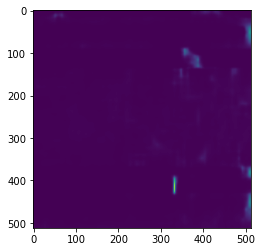

In [25]:
plt.imshow(F.softmax(outputs['out'][idx].squeeze()).cpu())

In [69]:
sample.shape

torch.Size([12, 5, 512, 512])

In [68]:
plt.imshow(outputs['out'][0,0])

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f25243eb0e0>
Traceback (most recent call last):
  File "/home/anmolnagi199/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/home/anmolnagi199/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/opt/conda/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


Error in callback <function flush_figures at 0x7f256e4cfb90> (for post_execute):


KeyboardInterrupt: 

In [ ]:

    
model.eval()
model.to(device)

# get the meta data of just one file
tiles = glob.glob(os.path.join(path_to_tiles, '*.jp2'))
src_vrt = rio.open(df['path_img'][0])

for i, sample in tqdm(enumerate(test_loader)):
    
    with torch.no_grad():
        inputRGB = sample[0].to(device)
        outputs, pred_vecmaps = model(inputRGB)
    
    for i in range(len(inputRGB)):

    #     develop output image mask
        pred = (F.softmax(outputs[3].detach().cpu(), dim=1))[i,1,:,:]

        _pred = np.stack([pred, pred, pred], axis = 0) * 255
        _pred = _pred.astype(np.uint8)

        
    #     develop meta file
        meta = {}

        meta['driver'] = 'GTiff'    # rasterio can write only with GTiff driver
        meta['dtype'] = src_vrt.meta['dtype']
        meta['nodata'] = src_vrt.meta['nodata']
        meta['width'] = int(sample[1]['_meta']['width'][i])
        meta['height'] = int(sample[1]['_meta']['height'][i])
        meta['count'] = 3
        meta['crs'] = src_vrt.meta['crs']

        a = float(sample[1]['transform'][0][i])
        b = float(sample[1]['transform'][1][i])
        c = float(sample[1]['transform'][2][i])
        d = float(sample[1]['transform'][3][i])
        e = float(sample[1]['transform'][4][i])
        f = float(sample[1]['transform'][5][i])

        meta['transform'] = rio.Affine(a, b, c, d, e, f)

    #     saving the mask
        names = sample[2]
        output_filename = names[i].replace('.jp2', '.jp2')   # change output format to tif as using GTiff driver

        outpath = os.path.join(path_to_save_mask, output_filename)

        with rio.open(outpath, 'w', **meta) as outds:
            outds.write(_pred)